In [171]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

In [172]:
from sklearn.datasets import load_wine

data = load_wine()

In [173]:
X = np.array(data['data'])
Y = np.array(data['target'], dtype=int)

In [174]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, Y):
    X_train, Y_train = X[train_index, :], Y[train_index]
    X_test, Y_test = X[test_index, :], Y[test_index]

In [175]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [176]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

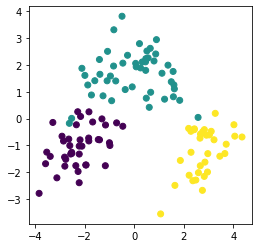

In [177]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)

In [178]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy_score(Y_test, Y_test_pred)

0.9444444444444444

(-4.549207615553604, 4.810792384446197)

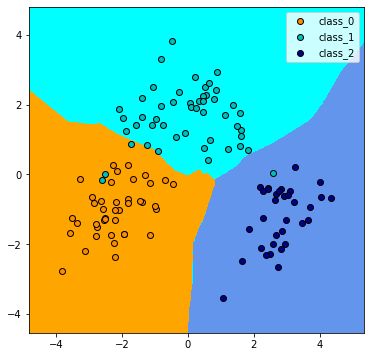

In [179]:
import seaborn as sns
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
X_grid_full = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
Z = knn.predict(X_grid_full)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
for y, label in enumerate(data.target_names):
    mask = Y_train == y
    plt.scatter(X_train_2D[mask, 0], X_train_2D[mask, 1],  label=label,
                color=cmap_bold[y], alpha=1.0, edgecolors="black")
plt.legend()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [180]:
def loss(X, Y, W, e, c):
    # n = X.shape[0]
    Y = Y[: ,None]
    # c /= n
    T = np.where(np.equal(Y, Y.T), 1, -1)
    N = sum(T == 1, 1)
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    return (np.sum(np.square(W)) / 2 +
            c * sum(np.maximum(sum(np.maximum(T * (D + D.T - 2 * P - e) + 1, 0), 1) - N + 1, 0))
           )

In [181]:
def grad(X, Y, W, e, c):
    # n = X.shape[0]
    Y = Y[:, None]
    # c /= n
    T = np.where(np.equal(Y, Y.T), 1, -1)
    N = sum(T == 1, 1)
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e) + 1
    E = sum(np.maximum(Z, 0), 1) - N + 1
    V = ((E > 0)[:, None] + (Z > 0)) * T
    U = V.diagonal()[:, None]
    dW = W + c * (X.T @ (U + U.T - V - V.T) @ X)
    de = -c * np.sum(V)
    return dW, de

In [182]:
c = 1
d = X_train_scaled.shape[1]
W = np.zeros((d,d)) # np.identity(d) # / np.sqrt(d)
e = 0
lr = .001
lr_up = ((1+np.sqrt(5))/2) ** (1/10)
lr_down = ((1+np.sqrt(5))/2) ** -1
armijo = .000001;
escale = 10

for i in range(1):
    print(loss(X_train_scaled, Y_train, W, e, c) / c)
    dW, de = grad(X_train_scaled, Y_train, W, e, c)
    W -= lr * dW
    e -= lr * de

10230.0
